# AR(p)
# Autoregressive Model
In a moving average model as we saw with Holt-Winters, we forecast the variable of interest using a linear combination of predictors. In our example we forecasted numbers of airline passengers in thousands based on a set of level, trend and seasonal predictors.

In an autoregression model, we forecast using a linear combination of <em>past values</em> of the variable. The term <em>autoregression</em> describes a regression of the variable against itself. An autoregression is run against a set of <em>lagged values</em> of order $p$.

### $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$

where $c$ is a constant, $\phi_{1}$ and $\phi_{2}$ are lag coefficients up to order $p$, and $\varepsilon_{t}$ is white noise.

For example, an <strong>AR(1)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

whereas an <strong>AR(2)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \varepsilon_{t}$

and so on.

Note that the lag coeffients are usually less than one, as we usually restrict autoregressive models to stationary data.<br>
Specifically, for an <strong>AR(1)</strong> model: $-1 \lt \phi_1 \lt 1$<br>
and for an <strong>AR(2)</strong> model: $-1 \lt \phi_2 \lt 1, \ \phi_1 + \phi_2 \lt 1, \ \phi_2 - \phi_1 \lt 1$<br>

Models <strong>AR(3)</strong> and higher become mathematically very complex. Fortunately statsmodels does all the heavy lifting for us.




## Perform standard imports and load datasets
For this exercise we'll look at monthly U.S. population estimates in thousands from January 2011 to December 2018 (96 records, 8 years of data). Population includes resident population plus armed forces overseas. The monthly estimate is the average of estimates for the first of the month and the first of the following month.

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

In [3]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/timeseries/Data/uspopulation.csv

--2021-04-13 13:21:33--  https://frenzy86.s3.eu-west-2.amazonaws.com/timeseries/Data/uspopulation.csv
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.148.78
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.148.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1571 (1.5K) [application/vnd.ms-excel]
Saving to: ‘uspopulation.csv’

uspopulation.csv    100%[===================>]   1.53K  --.-KB/s    in 0s      

2021-04-13 13:21:33 (81.2 MB/s) - ‘uspopulation.csv’ saved [1571/1571]



In [4]:
# Load specific forecasting tools
from statsmodels.tsa.ar_model import AR,ARResults

# Load the U.S. Population dataset
df = pd.read_csv('uspopulation.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
df.head()

,PopEst
DATE,
2011-01-01,311037
2011-02-01,311189
2011-03-01,311351
2011-04-01,311522
2011-05-01,311699


## Plot the source data

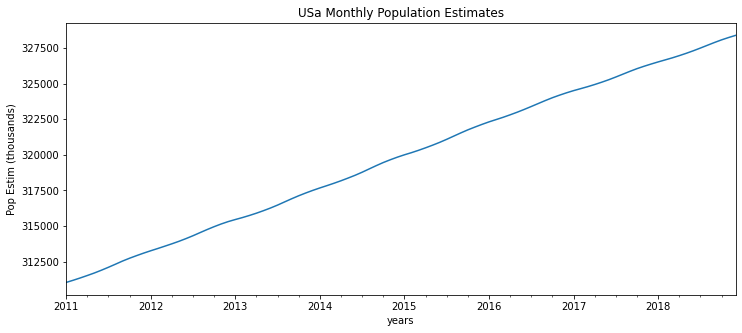

In [21]:
title='USa Monthly Population Estimates'
ylabel='Pop Estim (thousands)'
xlabel='years' # we don't really need a label here

ax = df['PopEst'].plot(figsize=(12,5),title=title);
ax.set(xlabel=xlabel, ylabel=ylabel);

## Split the data into train/test sets
The goal in this section is to:
* Split known data into a training set of records on which to fit the model
* Use the remaining records for testing, to evaluate the model
* Fit the model again on the <em>full</em> set of records
* Predict a future set of values using the model

As a general rule you should set the length of your test set equal to your intended forecast size. That is, for a monthly dataset you might want to forecast out one more year. Therefore your test set should be one year long.

<div class="alert alert-info"><strong>NOTE: </strong>For many training and testing applications we would use the <tt>train_test_split()</tt> function available from Python's <a href='https://scikit-learn.org/stable/'>scikit-learn</a> library. This won't work here as <tt>train_test_split()</tt> takes <em>random samples</em> of data from the population.</div>

In [22]:
 len(df)

96

In [23]:
96-12

84

In [24]:
# Set one year for testing
train = df.iloc[:84]
test = df.iloc[84:]

In [25]:
train

,PopEst
DATE,
2011-01-01,311037
2011-02-01,311189
2011-03-01,311351
2011-04-01,311522
2011-05-01,311699
...,...
2017-08-01,325667
2017-09-01,325866
2017-10-01,326054


## Fit an AR(1) Model

In [11]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [12]:
model = AR(train['PopEst'])
AR1fit = model.fit(maxlag=1,
                   method='mle') #maximum likelihood estimation (MLE)

print(f'Lag: {AR1fit.k_ar}')
print(f'Coefficients:\n{AR1fit.params}')

Lag: 1
Coefficients:
const        239.608395
L1.PopEst      0.999249
dtype: float64


<div class="alert alert-info"><strong>NOTE: </strong>There's a slight difference between the object returned by the Holt-Winters Exponential Smoothing <tt>.fit()</tt> method and that returned by AR. The Holt-Winters object uses <tt>.forecast()</tt> for predicted values, while AR uses <tt>.predict()</tt>.</div>

In [13]:
# This is the general format for obtaining predictions
start=len(train)
end=len(train)+len(test)-1
predictions1 = AR1fit.predict(start=start, end=end).rename('AR(1) Predictions')

In [14]:
predictions1

2018-01-01    326372.439456
2018-02-01    326366.883090
2018-03-01    326361.330897
2018-04-01    326355.782875
2018-05-01    326350.239021
2018-06-01    326344.699331
2018-07-01    326339.163802
2018-08-01    326333.632432
2018-09-01    326328.105216
2018-10-01    326322.582153
2018-11-01    326317.063238
2018-12-01    326311.548469
Freq: MS, Name: AR(1) Predictions, dtype: float64

In [15]:
test.head()

,PopEst
DATE,
2018-01-01,326527
2018-02-01,326669
2018-03-01,326812
2018-04-01,326968
2018-05-01,327134


In [16]:
# Comparing predictions to expected values
for i in range(len(predictions1)):
    print(f"predicted={predictions1[i]:<11.10}, expected={test['PopEst'][i]}")

predicted=326372.4395, expected=326527
predicted=326366.8831, expected=326669
predicted=326361.3309, expected=326812
predicted=326355.7829, expected=326968
predicted=326350.239 , expected=327134
predicted=326344.6993, expected=327312
predicted=326339.1638, expected=327502
predicted=326333.6324, expected=327698
predicted=326328.1052, expected=327893
predicted=326322.5822, expected=328077
predicted=326317.0632, expected=328241
predicted=326311.5485, expected=328393


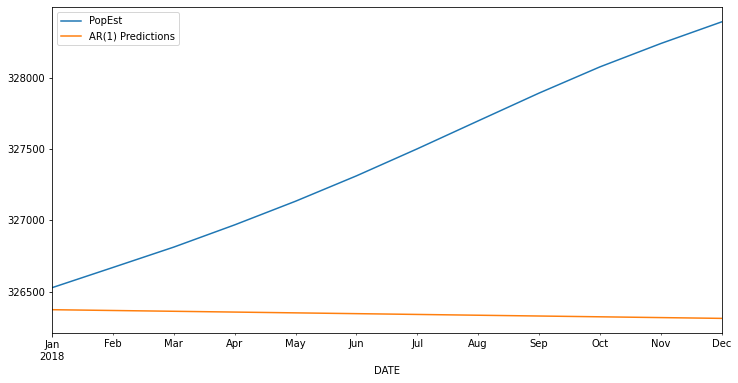

In [17]:
test['PopEst'].plot(legend=True)
predictions1.plot(legend=True,figsize=(12,6));

## Fit an AR(2) Model

In [19]:
# Recall that our model was already created above based on the training set
AR2fit = model.fit(maxlag=2,
                   method='mle')#maximum likelihood estimation (MLE)

print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')

Lag: 2
Coefficients:
const        119.907722
L1.PopEst      1.996371
L2.PopEst     -0.996747
dtype: float64


In [20]:
start=len(train)
end=len(train)+len(test)-1
predictions2 = AR2fit.predict(start=start, end=end).rename('AR(2) Predictions')

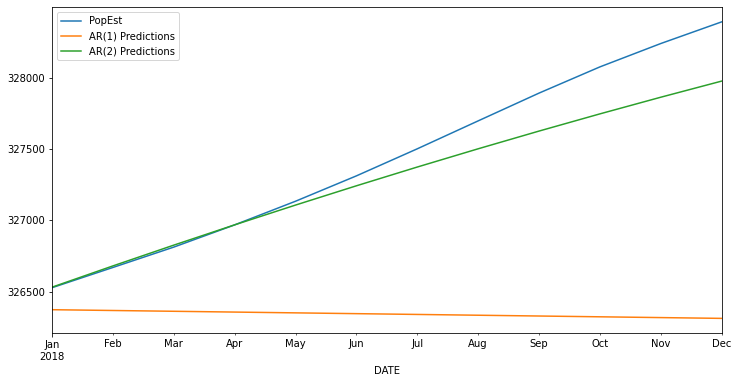

In [ ]:
test['PopEst'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

## Fit an AR(p) model where statsmodels chooses p
This time we'll omit the <tt>maxlag</tt> argument in <tt>AR.fit()</tt> and let statsmodels choose a p-value for us.

In [ ]:
ARfit = model.fit(method='mle') #maximum likelihood estimation (MLE)

print(f'Lag: {ARfit.k_ar}')
print(f'Coefficients:\n{ARfit.params}')

Lag: 11
Coefficients:
const         96.211909
L1.PopEst      2.230894
L2.PopEst     -1.983321
L3.PopEst      1.515178
L4.PopEst     -1.440421
L5.PopEst      1.202985
L6.PopEst     -1.162426
L7.PopEst      1.006187
L8.PopEst     -0.591689
L9.PopEst      0.591492
L10.PopEst    -0.338822
L11.PopEst    -0.030358
dtype: float64


In [ ]:
start = len(train)
end = len(train)+len(test)-1
rename = f'AR(11) Predictions'

predictions11 = ARfit.predict(start=start,end=end,dynamic=False).rename(rename)

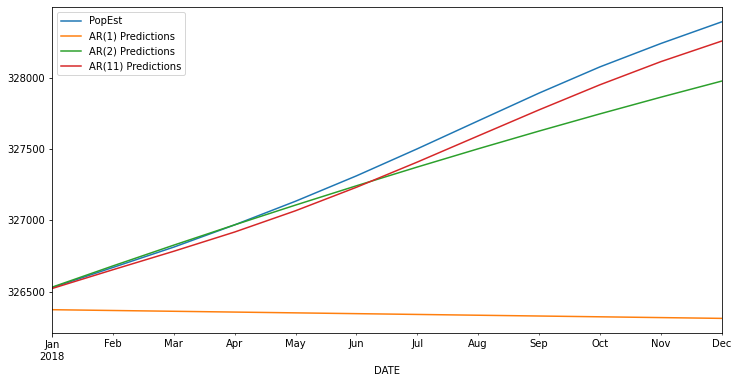

In [ ]:
test['PopEst'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions11.plot(legend=True,figsize=(12,6));

## Evaluate the Model
It helps to have a means of comparison between two or more models. One common method is to compute the Mean Squared Error (MSE), available from scikit-learn.

In [ ]:
from sklearn.metrics import mean_squared_error

labels = ['AR(1)','AR(2)','AR(11)']
preds = [predictions1, predictions2, predictions11]  # these are variables, not strings!

for i in range(3):
    error = mean_squared_error(test['PopEst'], preds[i])
    print(f'{labels[i]} MSE error was: {error}')

AR(1) MSE error was: 1584797.131994238
AR(2) MSE error was: 46289.81782500793
AR(11) MSE error was: 8199.840801538687


We see right away how well AR(11) outperformed the other two models.

Another method is the <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'>Akaike information criterion</a> (AIC), which does a better job of evaluating models by avoiding overfitting.<br>
Fortunately this is available directly from the fit model object.

In [ ]:
modls = [AR1fit,AR2fit,ARfit]

for i in range(3):
    print(f'{labels[i]} AIC: {modls[i].aic:6.5}')

AR(1) AIC: 3.3939
AR(2) AIC: 3.4177
AR(11) AIC:  3.632


## Forecasting on total Dataset
Now we're ready to train our best model on the greatest amount of data, and fit it to future dates.

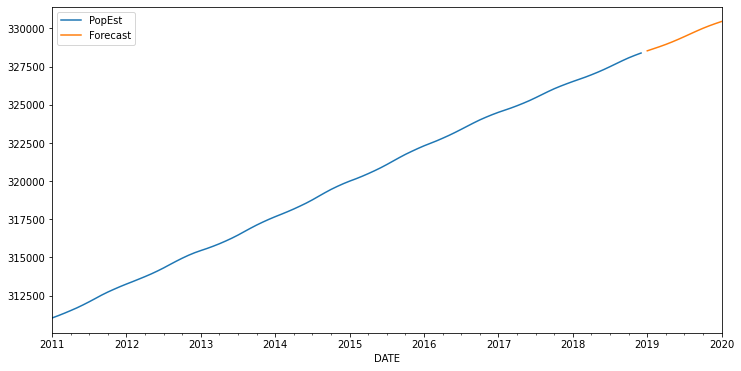

In [26]:
# First, retrain the model on the full dataset
model = AR(df['PopEst'])

# Next, fit the model
ARfit = model.fit()

# Make predictions one year --> end=len(df)+12
forecast = ARfit.predict(start=len(df), 
                      end=len(df)+12, 
                      dynamic=False).rename('Forecast') 

# Plot the results
df['PopEst'].plot(legend=True)
forecast.plot(legend=True,figsize=(12,6));